<a href="https://colab.research.google.com/github/zdemanche/Transformers4095/blob/main/finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2

Last lecture, we learned about fine-tuning and transfer learning. In this homework, we will practice these techniques on a transformer model. We will once again be using the BERT model and training it on the IMDB dataset.

The IMDB dataset is a binary sentiment classification dataset. It consists of 50,000 movie reviews, each marked as either positive or negative.

Run the following cell to install the relevant libraries to your environment.

In [ ]:
! pip install accelerate transformers datasets
! pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel, BertConfig
from datasets import load_dataset
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import torch

Now let's download the dataset. Thankfully, Huggingface has a library that allows us to easily download and use the IMDB dataset. Run the following cell to download the dataset.

In [ ]:
dataset = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Let's see some examples of the dataset. Run the following cell to see an example of a positive and negative review.

In [ ]:
print("Positive example: \n", dataset["train"][15780], "\n")
print("Negative example: \n", dataset['train'][7220], "\n")

Positive example: 
 {'text': "I don't know why I like this movie so well, but I never get tired of watching it.", 'label': 1} 

Negative example: 
 {'text': 'no comment - stupid movie, acting average or worse... screenplay - no sense at all... SKIP IT!', 'label': 0} 



Now that we've seen the data, set us prepare our training and evaluation data. Run the following cell to prepare the data.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = dataset["test"].shuffle(seed=42).select(range(1000))

small_train_dataset = small_train_dataset.map(tokenize_function, batched=True)
small_eval_dataset = small_eval_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

We then load the BERT model to train the model. For this homework, we're going to use the `BertForSequenceClassification` class. This constructs an architecture that is suitable for sequence classification tasks, which we are doing in this homework. It loads the BERT model and adds a classifier layer on top of it, as can be seen in the image below.
<p align="center">
<img src="https://lh3.googleusercontent.com/d/1rzFZZ1IB1KHKgQjtGbFyaMxu2bEjPy5F" alt="BertForSequenceClassification Architecture" height="368" />
<div align="center">
  Bert For Sequence Classification Architecture
</div>
</p>

Run the below cell to load the BERTForSequenceClassification model.

In [ ]:
model1 = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now that we have the model and data ready, we can start training the model. Run the following cell to first load the helper functions to train the model.

In [ ]:
id2label = {0: "negative", 1: "positive"}

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

def train_model(model, batch_size = 16, epochs = 5, gradient_checkpointing = False, out_dir = "test_trainer"):

    training_args = TrainingArguments(
        output_dir = out_dir,
        evaluation_strategy="epoch",
        per_device_train_batch_size = batch_size,
        gradient_accumulation_steps = 4,
        gradient_checkpointing = gradient_checkpointing,

        fp16 = True,
        num_train_epochs = epochs
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    return trainer

Finally, we can begin training the model. We will be training both the BERT model and the classifier layer on top of it onto the IMDB dataset to perform sentiment classification (tell if a review is positive or negative).

We will train the model for only 5 epochs. This may not seem like a lot, but we will show how the transformer model can fit the data really well with very few learning steps.


Note: This will take a long time to train. We HIGHLY RECOMMEND using Colab to train this model, as a GPU is required to train this model in a reasonable amount of time. If you are using Colab, make sure to change the runtime to use a GPU.

Run the following cell to train the model.

In [ ]:
trainer_m1 = train_model(model1, batch_size = 16, epochs = 5, gradient_checkpointing = True, out_dir = "model1")

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.383843,0.858000
1,No log,0.416276,0.829000
2,No log,0.353130,0.857000
4,No log,0.307810,0.890000


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

# 1) Material Review / Model 1 Training (10 pts.)

While the model is training, let's review some of the concepts we learned in class.

### What kind of transformer architecture is BERT (e.g. Encoder, Decoder, Encoder-Decoder)? Explain.

In [ ]:
# Answer the above question below:

'''
BERT is an encoder transformer architecture because it needs to examine words bidirectionally which means examine those words left-right and right-left. Also make sure they're in the right order.
BERT stands for: Bidirectional Encoder Representations from Transformers

'''

### Why are we using that kind of architecture for this task, rather than a different architecture?

In [ ]:
# Answer the above question below:

'''
We use encoder architecture for this task because we're trying to train datasets positively and negatively, making sure those datasets are also in the right order alphabetically.

'''

### Why do we need to add an additional classifier (linear) layer on top of the BERT model?

In [ ]:
# Answer the above question below:

'''
We add additional linear layers on top of the BERT model because this layer takes the BERT embeddings and transforms them into vectors so the computer can compute the target output.

'''

### We are training / have trained both the BERT model and the classifier layer on the IMDB dataset. What type of training is this (e.g. fine-tuning, transfer learning, pre-training)? Explain.

In [ ]:
# Answer the above question below:

'''
Transfer learning because we took an already taught model such as the BERT model and trained that model with the IMDB dataset.

'''

### Continue past this point once the model has finished training.

Now that the model has finished training, let's evaluate the model ourselves.

Run the following cell to evaluate the model on some example sentences. (1 pt.)


Feel free to change the sentence, in the `txt` variable, to see how the model performs on different inputs.

In [ ]:
# Test the model

txt = "Zach is somewhat alright at school"

inputs = tokenizer(txt, return_tensors="pt").to(model1.device)

outputs = model1(**inputs)

logits = outputs.logits

predicted_class_idx = logits.argmax(-1)


print("Input:", txt)
print("Predicted class:", id2label[predicted_class_idx.item()], predicted_class_idx.item())

Input: Zach is somewhat alright at school
Predicted class: positive 1


Let us now train a new model for the same task. This time we will freeze the BERT model layers, as in not train BERT, and only train the classifier layer on top of it.

As all the learning in the model will be done in the classifier layer, we should make the classifier more robust to solely analyze the complex features and compensate for the lack of learning in the BERT model. We do this by adding more layers to the classifier, creating a Multi-Layer Classifier. We will also increase the number of epochs to 15 to give the model more time to learn.


Below is an image of the architecture of the new model.

<p align="center">
<img src="https://lh3.googleusercontent.com/d/1VlB3N8gRgVzcrrUzpJ2vq2ZtNeujXmz0" alt="BertWithMultiLayerClassifier Architecture" height="368" />
<div align="center">
  Bert With Multi-Layer Classifier Architecture
</div>
</p>

We manually define the new model in the following cell. Run the cell below to load the new model.

In [ ]:
class BertWithMultiLayerClassifier(BertForSequenceClassification):
    def __init__(self, bert_model, num_labels):
        super().__init__(config=BertConfig())
        self.bert = bert_model

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(768, 768),
            torch.nn.ReLU(),
            torch.nn.Linear(768, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_labels)
        )

        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, labels=None, output_attentions=None, output_hidden_states=None, return_dict=None):
        return super().forward(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, position_ids=position_ids, head_mask=head_mask, inputs_embeds=inputs_embeds, labels=labels, output_attentions=output_attentions, output_hidden_states=output_hidden_states, return_dict=return_dict)


model2 = BertWithMultiLayerClassifier(BertModel.from_pretrained("bert-base-uncased"), 2)

Now that we have the model loaded, we can start training it. As we're only training the classifier layer on top of the BERT model, training should be much faster per epoch. We however still recommend having a GPU available or using Colab to train this model in a reasonable amount of time.

Run the following cell to train the new model.

In [ ]:
trainer_m2 = train_model(model2, batch_size = 16, epochs = 15, gradient_checkpointing = False, out_dir = "model2")

Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.691974,0.555000
1,No log,0.690018,0.592000
2,No log,0.686157,0.595000
4,No log,0.673650,0.611000
5,No log,0.667897,0.609000
6,No log,0.654952,0.638000
8,No log,0.634737,0.666000
9,No log,0.624626,0.681000
10,No log,0.616955,0.688000
12,No log,0.610260,0.709000


## 2) Model 2 Training (4 pts.)

While the model is training, let's analyze Model 2.

### In this new model, we are only training the classifier layer on top of the BERT model, and not training the BERT model itself. What type of training is this (e.g. fine-tuning, transfer learning, pre-training)? Explain.

In [ ]:
# Answer the above question below:

'''
Fine tuning training because your using the already trained BERT model with the newly trained classifier layer.

'''

### We mentioned that we are adding more layers to the classifier (a feedforward neural network) to compensate for the lack of learning in the BERT model. Why would the classifier need to be more robust in this case (i.e. what do Transformers have that neural networks lack)?

In [ ]:
# Answer the above question below:

'''
Transformers use attention to capture and read the words or tokens simultaneously while neural networks capture and reads word by word or token by token. Transformers are also a type of neural network because neural network is such a large term.


'''

### Continue past this point once the model has finished training.

Now that the model has finished training, let's evaluate the model ourselves.

Run the following cell to evaluate the model on some example sentences. (1 pt.)


Feel free to change the sentence, in the `txt` variable, to see how the model performs on different inputs.

In [ ]:
# Test the model

txt = "I hate this movie. It's terrible!"

inputs = tokenizer(txt, return_tensors="pt").to(model2.device)

outputs = model2(**inputs)

logits = outputs.logits

predicted_class_idx = logits.argmax(-1)


print("Input:", txt)
print("Predicted class:", id2label[predicted_class_idx.item()], predicted_class_idx.item())

Input: I hate this movie. It's terrible!
Predicted class: negative 0


## 3) Model Comparison (11 pts.)

Now that we have trained both models, let's compare the two models. We'll now plot the accuracy of the two models over the epochs to see how they compare. This is comparing the number of correct predictions the model made over the total number of predictions made from the evaluation data, out of 1 (meaning 100% accuracy).

Run the following cell to generate a graph comparing the accuracy of the two models. (3 pts.)

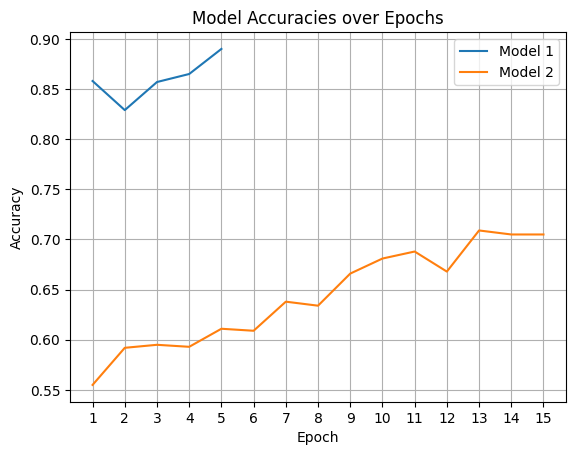

In [ ]:
def metric_prepare(trainer, met):
    met_val = [(x[met], x['epoch']) for x in trainer.state.log_history if met in x]
    met_val, epoch = zip(*met_val)

    return met_val

m1_acc = metric_prepare(trainer_m1, "eval_accuracy")
m2_acc = metric_prepare(trainer_m2, "eval_accuracy")

plt.plot(range(1, len(m1_acc) + 1), m1_acc, label="Model 1")
plt.plot(range(1, len(m2_acc) + 1), m2_acc, label="Model 2")

plt.xticks(range(1, len(m2_acc) + 1))

plt.grid()

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title("Model Accuracies over Epochs")

plt.show()

Note that the Model 1 lineplot stops at 5 epochs, as we only trained it for 5 epochs. The Model 2 lineplot goes up to 15 epochs, as we trained it for 15 epochs.

### What do you notice about the accuracy of the two models? What can you infer from this?

In [ ]:
# Answer the above question below:

'''
Model 1 is also very short but it has more accuracy in a shorter time period.

'''

Now we'll compare the loss of the two models over the epochs.

`Loss` is a measure of how poorly the model is performing, as in, how much it needs to be adjusted. The lower the loss, the better the model is at predicting the dataset. The larger the loss, the more the model needs to be changed to make better predictions. During training, we try to minimize the loss of the model at each step (if you are familiar with the cost function, loss is a component of the function).

Run the following cell to generate a graph comparing the loss of the two models. (3 pts.)

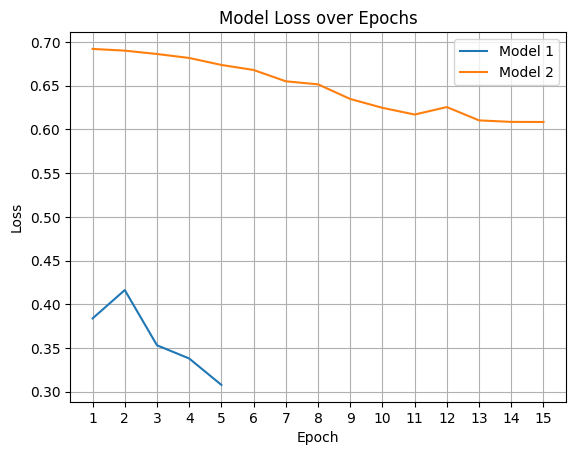

In [ ]:
m1_loss = metric_prepare(trainer_m1, "eval_loss")
m2_loss = metric_prepare(trainer_m2, "eval_loss")

plt.plot(range(1, len(m1_loss) + 1), m1_loss, label="Model 1")
plt.plot(range(1, len(m2_loss) + 1), m2_loss, label="Model 2")

plt.xticks(range(1, len(m2_loss) + 1))

plt.grid()

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.title("Model Loss over Epochs")

plt.show()

### What do you notice about the loss of the two models? What can you infer from this?

In [ ]:
# Answer the above question below:

'''
Even though model 1 is more accurate it takes way more of a loss than model 2 and over a quicker period of time.

'''

## 4) (More) Material Review (8 pts.)

### Note in this homework that we've used two different types of training (e.g. fine-tuning, transfer learning, pre-training). One of them we can't do on this homework. Which one is it and why can't we do it? Provide two reasons.

In [ ]:
# Answer the above question below:

'''
The one that we can't do on this homework is pre-training because the BERT model was already trained before this homework. Also pre training a transformer model on the homework would take a while to complete.

'''

### What is the difference between fine-tuning, transfer learning, and pre-training? When do we use each of these techniques? Explain.

In [ ]:
# Answer the above question below:

'''
Pre training is building a base model on a massive, generic dataset. This training is used for the initial foundation for other tasks. Transfer learning is using a pre-trained model for a new task. This training is used for relatively small datasets, but used for similar tasks as pre training. Fine tuning is specializing a pre-trained model to a specific dataset. This training is used to improve performance on a model and more task specific behaviors.

'''